In [ ]:
"""
Framework   : OpenCV Aruco
Description : Calibration of camera and using that for finding pose of multiple markers
References  :
    1) https://docs.opencv.org/3.4.0/d5/dae/tutorial_aruco_detection.html
    2) https://docs.opencv.org/3.4.3/dc/dbb/tutorial_py_calibration.html
    3) https://docs.opencv.org/3.1.0/d5/dae/tutorial_aruco_detection.html
"""

import numpy as np
import cv2
import cv2.aruco as aruco
import glob
# NOTE: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
# to crash; see https://github.com/jupyter/notebook/issues/3935 as a substitution
from google.colab.patches import cv2_imshow

from matplotlib import pyplot as plt


In [ ]:
# OPENCV HAS 21 DIFFERENT ARUCO DICTIONARIES 

# ARUCO_DICT = {
# 	"DICT_4X4_50": cv2.aruco.DICT_4X4_50,
# 	"DICT_4X4_100": cv2.aruco.DICT_4X4_100,
# 	"DICT_4X4_250": cv2.aruco.DICT_4X4_250,
# 	"DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
# 	"DICT_5X5_50": cv2.aruco.DICT_5X5_50,
# 	"DICT_5X5_100": cv2.aruco.DICT_5X5_100,
# 	"DICT_5X5_250": cv2.aruco.DICT_5X5_250,
# 	"DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
# 	"DICT_6X6_50": cv2.aruco.DICT_6X6_50,
# 	"DICT_6X6_100": cv2.aruco.DICT_6X6_100,
# 	"DICT_6X6_250": cv2.aruco.DICT_6X6_250,
# 	"DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
# 	"DICT_7X7_50": cv2.aruco.DICT_7X7_50,
# 	"DICT_7X7_100": cv2.aruco.DICT_7X7_100,
# 	"DICT_7X7_250": cv2.aruco.DICT_7X7_250,
# 	"DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
# 	"DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
# 	"DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
# 	"DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
# 	"DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
# 	"DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
# }

In [ ]:
cap = cv2.VideoCapture(1)

####---------------------- CALIBRATION ---------------------------
# termination criteria for the iterative algorithm
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# checkerboard of size (7 x 6) is used
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# iterating through all calibration images
# in the folder
images = glob.glob('/content/drive/MyDrive/Colab Notebooks/CRL tutorials/photos/calib_images/checkerboard/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # find the chess board (calibration pattern) corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # if calibration pattern is found, add object points,
    # image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        # Refine the corners of the detected corners
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

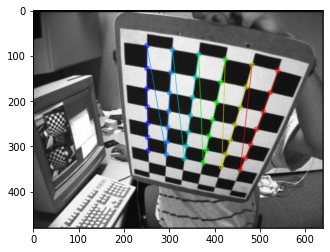

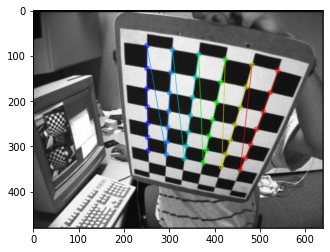

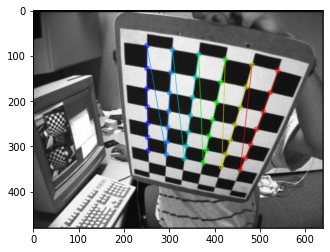

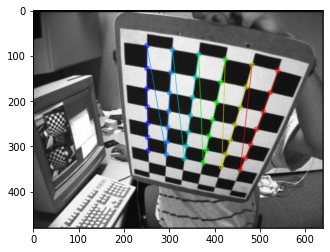

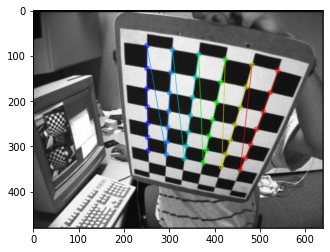

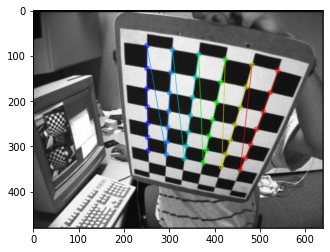

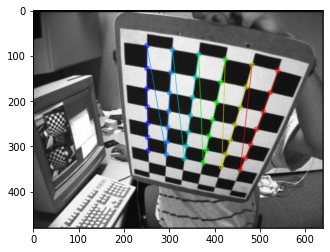

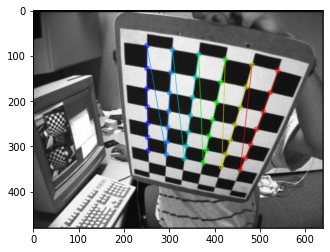

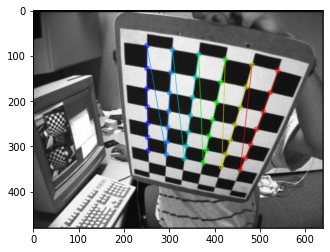

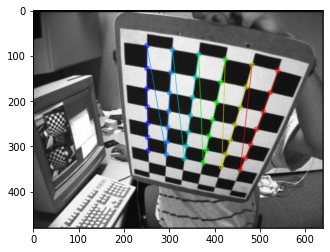

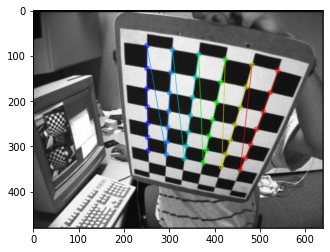

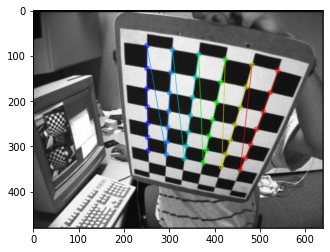

KeyboardInterrupt: ignored

In [ ]:
###------------------ ARUCO TRACKER ---------------------------
while (True):
    # ret, frame = cap.read()


    # operations on the frame
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # set dictionary size depending on the aruco marker selected
    aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)

    # detector parameters can be set here (List of detection parameters[3])
    parameters = aruco.DetectorParameters_create()
    parameters.adaptiveThreshConstant = 10

    # lists of ids and the corners belonging to each id
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)

    # font for displaying text (below)
    font = cv2.FONT_HERSHEY_SIMPLEX

    # check if the ids list is not empty
    # if no check is added the code will crash
    if np.all(ids != None):

        # estimate pose of each marker and return the values
        # rvet and tvec-different from camera coefficients
        rvec, tvec ,_ = aruco.estimatePoseSingleMarkers(corners, 0.05, mtx, dist)
        #(rvec-tvec).any() # get rid of that nasty numpy value array error

        for i in range(0, ids.size):
            # draw axis for the aruco markers
            aruco.drawAxis(frame, mtx, dist, rvec[i], tvec[i], 0.1)

        # draw a square around the markers
        aruco.drawDetectedMarkers(frame, corners)


        # code to show ids of the marker found
        strg = ''
        for i in range(0, ids.size):
            strg += str(ids[i][0])+', '

        cv2.putText(frame, "Id: " + strg, (0,64), font, 1, (0,255,0),2,cv2.LINE_AA)


    else:
        # code to show 'No Ids' when no markers are found
        cv2.putText(frame, "No Ids", (0,64), font, 1, (0,255,0),2,cv2.LINE_AA)

    # display the resulting frame
    plt.imshow(img)
    plt.show()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

Detect ArUco markers in Images


Detect ArUco markers in Real-Time Video Streams


- Verifying that at least one ArUco tag was detected
- Flattening the ArUco ids list
- Looping over all corners and ids together
- Extracting the marker corners in top-left, top-right, bottom-right, and bottom-left order
- Converting the corner (x, y)-coordinates from NumPy array data types to Python integers such that we can draw the coordinates using OpenCV’s drawing functions

In [ ]:
# import the necessary packages
from imutils.video import VideoStream
import argparse
import imutils
import time
import cv2
import sys

In [ ]:
# define names of each possible ArUco tag OpenCV supports
ARUCO_DICT = {
	"DICT_4X4_50": cv2.aruco.DICT_4X4_50,
	"DICT_4X4_100": cv2.aruco.DICT_4X4_100,
	"DICT_4X4_250": cv2.aruco.DICT_4X4_250,
	"DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
	"DICT_5X5_50": cv2.aruco.DICT_5X5_50,
	"DICT_5X5_100": cv2.aruco.DICT_5X5_100,
	"DICT_5X5_250": cv2.aruco.DICT_5X5_250,
	"DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
	"DICT_6X6_50": cv2.aruco.DICT_6X6_50,
	"DICT_6X6_100": cv2.aruco.DICT_6X6_100,
	"DICT_6X6_250": cv2.aruco.DICT_6X6_250,
	"DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
	"DICT_7X7_50": cv2.aruco.DICT_7X7_50,
	"DICT_7X7_100": cv2.aruco.DICT_7X7_100,
	"DICT_7X7_250": cv2.aruco.DICT_7X7_250,
	"DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
	"DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
	"DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
	"DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
	"DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
	"DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
}


In [ ]:
# verify that the supplied ArUCo tag exists and is supported by
# OpenCV
if ARUCO_DICT.get(args["type"], None) is None:
	print("[INFO] ArUCo tag of '{}' is not supported".format(
		args["type"]))
	sys.exit(0)
 
# load the ArUCo dictionary and grab the ArUCo parameters
print("[INFO] detecting '{}' tags...".format(args["type"]))
arucoDict = cv2.aruco.Dictionary_get(ARUCO_DICT[args["type"]])
arucoParams = cv2.aruco.DetectorParameters_create()

# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)

NameError: ignored

In [ ]:
# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 1000 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=1000)
	# detect ArUco markers in the input frame
	(corners, ids, rejected) = cv2.aruco.detectMarkers(frame,
		arucoDict, parameters=arucoParams)

In [ ]:
	# verify *at least* one ArUco marker was detected
	if len(corners) > 0:
		# flatten the ArUco IDs list
		ids = ids.flatten()
		# loop over the detected ArUCo corners
		for (markerCorner, markerID) in zip(corners, ids):
			# extract the marker corners (which are always returned
			# in top-left, top-right, bottom-right, and bottom-left
			# order)
			corners = markerCorner.reshape((4, 2))
			(topLeft, topRight, bottomRight, bottomLeft) = corners
			# convert each of the (x, y)-coordinate pairs to integers
			topRight = (int(topRight[0]), int(topRight[1]))
			bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
			bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
			topLeft = (int(topLeft[0]), int(topLeft[1]))
   
#----------------draw the ArUco tag bounding boxes----------------#
   		
       # draw the bounding box of the ArUCo detection
			cv2.line(frame, topLeft, topRight, (0, 255, 0), 2)
			cv2.line(frame, topRight, bottomRight, (0, 255, 0), 2)
			cv2.line(frame, bottomRight, bottomLeft, (0, 255, 0), 2)
			cv2.line(frame, bottomLeft, topLeft, (0, 255, 0), 2)
			# compute and draw the center (x, y)-coordinates of the
			# ArUco marker
			cX = int((topLeft[0] + bottomRight[0]) / 2.0)
			cY = int((topLeft[1] + bottomRight[1]) / 2.0)
			cv2.circle(frame, (cX, cY), 4, (0, 0, 255), -1)
			# draw the ArUco marker ID on the frame
			cv2.putText(frame, str(markerID),
				(topLeft[0], topLeft[1] - 15),
				cv2.FONT_HERSHEY_SIMPLEX,
				0.5, (0, 255, 0), 2)
	# show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF
	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break
# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()